In [1]:
import math
import numpy as np
import torch
import torch.optim as optim
from torchvision import models
from torchvision import transforms as T
from PIL import Image, ImageChops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def read_img(path, max_element):
    '''读入图像，resize到宽度*高度不超过max_element'''
    with Image.open(path) as im:
        W, H = im.size
        coef = math.sqrt(max_element / (W * H))
        W, H = int(math.floor(W * coef)), int(math.floor(H * coef))
        return im.resize((W, H), resample=Image.BICUBIC)
def make_imgs(img, L):
    '''图像金字塔'''
    W, H = img.size
    ret = []
    while W >= L and H >= L:
        ret.append(img.resize((W, H), resample=Image.BICUBIC))
        W, H = W // 2, H // 2
    return ret

In [3]:
net = models.vgg16(pretrained=True)
net = net.features
_ = net.requires_grad_(False)
_ = net.cuda()

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])
img_trans = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
def trans(img):
    '''图像转换为网络输入'''
    return img_trans(img)[np.newaxis]
def untrans(tensor):
    '''网络输出转换为图像'''
    tensor = tensor[0].cpu() * std.reshape(-1, 1, 1) + mean.reshape(-1, 1, 1)
    torch.clip_(tensor, 0, 1)
    tensor = torch.permute(tensor, [1, 2, 0]).numpy()
    return Image.fromarray(np.uint8(tensor * 255))

In [5]:
def forward_n(net, img, level):
    '''求第level层的输出结果'''
    for i, layer in enumerate(net):
        if i == level: break
        img = layer(img)
    return img

In [6]:
def dream_once(net, img, level, ite, lr, decay):
    '''对一张图片dream'''
    img = trans(img).cuda()
    coef = torch.abs(img)
    disturb = torch.zeros_like(img).cuda()
    disturb.requires_grad_(True)
    optimizer = optim.Adam([disturb], lr=lr)
    for i in range(ite):
        loss = -torch.norm(forward_n(net, img + disturb, level)) + decay * (coef * torch.abs(disturb)).sum()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    img = img + disturb.detach()
    return untrans(img + disturb.detach())

In [7]:
def dream(net, img, level, ite, lr, decay, blend, verbose=False):
    '''金字塔分级dream'''
    W, H = img.size
    imgs = make_imgs(img, 128)
    rg = list(reversed(range(len(imgs))))
    if verbose: rg = tqdm(rg)
    img = None
    for i in rg:
        if img is not None:
            img = img.resize(imgs[i].size, Image.ANTIALIAS)
            img = ImageChops.blend(imgs[i], img, blend)
        else:
            img = imgs[i]
        cW, cH = imgs[i].size
        img = dream_once(net, img, level, ite, lr, decay)
    return img

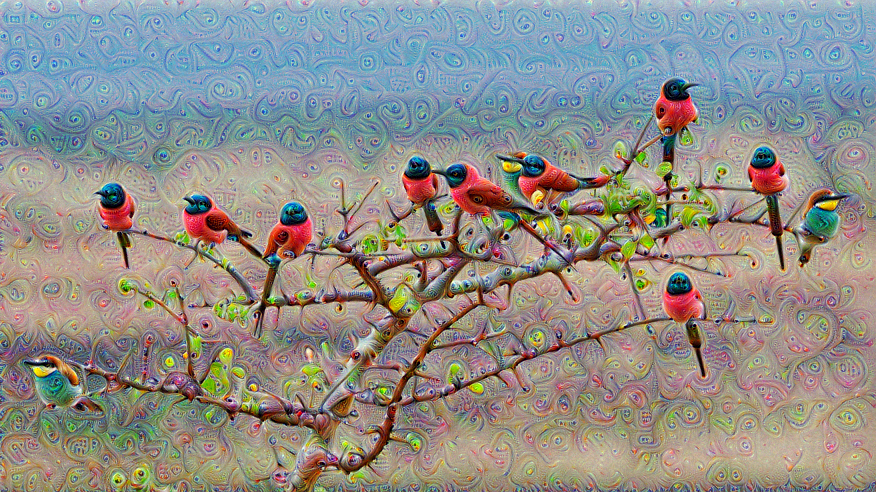

In [11]:
img = read_img('img.jpg', 800 * 540)
out = dream(net, img, 17, 5, 0.08, 0.08, 0.6)
out.save('dream.png')
out

# 将视频转换为 deep dream

In [ ]:
!mkdir images
!ffmpeg -i video.mp4 -vf fps=20 images/%03d.png

In [ ]:
out_root = Path('out')
out_root.mkdir(exist_ok=True)
files = sorted(Path('images').glob('*.png'))
max_element = 800 * 600
for f in tqdm(files):
    out = dream(net, read_img(f, max_element), 17, 5, 0.08, 0.08, 0.6)
    out.save(out_root.joinpath(f.name))

In [ ]:
!ffmpeg -r 20 -i out/%03d.png -c:v libx264 -vf fps=20 out.mp4 -y